### Install libraries

In [52]:
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install sklearn
# !pip3 install scipy
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install scikit-image

### Import libraries

In [86]:
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
%matplotlib inline

### Create dictionary for letters and their corresponding number
### Define number of channels (one for each primary colour, e.g. RGB has 3), in our case 1 because colours wouldn't help much with letter recognition and image data is in grayscale.

In [87]:
letter_numbers = {
    'ა': 1, 'ბ': 2, 'გ': 3, 'დ': 4, 'ე': 5, 'ვ': 6, 'ზ': 7, 'თ': 8, 'ი': 9, 'კ': 10, 'ლ': 11, 'მ': 12,
    'ნ': 13, 'ო': 14, 'პ': 15, 'ჟ': 16, 'რ': 17, 'ს': 18, 'ტ': 19, 'უ': 20, 'ფ': 21, 'ქ': 22, 'ღ': 23,
    'ყ': 24, 'შ': 25, 'ჩ': 26, 'ც': 27, 'ძ': 28, 'წ': 29, 'ჭ': 30, 'ხ': 31, 'ჯ': 32, 'ჰ': 33
}
X = []
y = []
number_of_channels = 1
X, y

([], [])

### Load image of letter to numpy array to show how our data would be represented

In [88]:
image_name = '4_aacadhn.ttf_fs_80_bc_256.ა.png'
path_to_train = './images/train'
image = Image.open(path_to_train + '/ა/' + image_name).convert('L')
str_before_letter = '256.'
image_letter = image_name[image_name.find(str_before_letter) + len(str_before_letter)]
y.append(letter_numbers[image_letter])
to_append = np.array(image.getdata(), dtype=np.uint8).reshape(image.size[0], image.size[1], number_of_channels)
X.append(to_append)
X = np.stack(X)
y = np.array(y)
X.shape, y.shape

((1, 100, 100, 1), (1,))

### Shape of X numpy array would be number_of_images x image_width x image_height x number_of_channels
### Using 8 bit unsigned integer to store values because each pixel value is in range 0-255 and if I decided to load data into numpy arrays the default 64 bit integer would take up lot more space, so uint8 is optimal and faster

### Below is an image represented by grayscale pixel values
### 0 (Black) to 255 (White)

In [89]:
print(np.resize(image.getdata(), (100, 100)))

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


### Visual representation of image

Image Width: 100 Image Height: 100


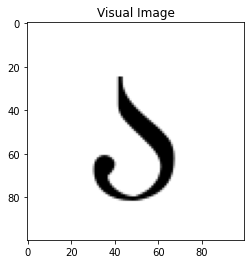

In [90]:
width, height = image.size
print(f'Image Width: {width}', f'Image Height: {height}')
plt.imshow(image, cmap='gray')
plt.title('Visual Image')
plt.show()

### The image pixel values would need to be normalized, because large integers tend to slow down learning process, so it is computationally efficient to reduce values between 0-1 range. We do this by dividing each pixel value by maximum (255)

In [91]:
X = X.astype('float32')
X = X / 255.0
X

array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]]], dtype=float32)

### Pixel values can be transformed back into original 100x100 images if needed

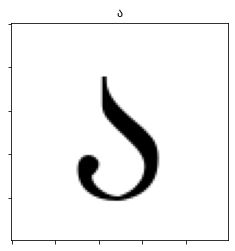

In [93]:
num_letters_to_display = 9
num_to_display_sqrt = math.ceil(math.sqrt(num_letters_to_display))
plt.imshow(X[0], cmap=plt.cm.binary_r)
plt.title(list(letter_numbers.keys())[list(letter_numbers.values()).index(y[0])])
plt.gca().axes.set_xticklabels([])
plt.gca().axes.set_yticklabels([])
plt.show()

### This part was for just showing data representation, I decided not to load images into numpy arrays as it took too much time

### As next step I define ImageDataGenerators to augment images to expand dataset, and as result there's more training examples. This prevents model from overfitting thus making it better at generalization and increasing prediction accuracy. It generates new images from existing data with different rotations, width/height shift and shearing (distortion along an axis). I also use ImageDataGenerator to rescale pixel values for reasons mentioned above.

In [94]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    rescale=1/255.0
    )

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

### Use flow_from_directory to generate augmented images directly from local directory and feed it to model. It is more efficient as it saves time and memory by not loading all the data into arrays first. Images will get resized to target_size, training dataset contains 100x100 images so while it is faster to train model with smaller pictures there's also downside to it, by decreasing image size we lose some data but it is mostly negligible

### class_mode='categorical' makes it so that labels are one hot encoded 
### shuffle=True is used so that the model doesn't memorize image sequence
### color_mode='grayscale' converts image to have 1 channel
### Setting batch_size to 1 because bigger values seemed to cause error and predict single letter for all images

In [95]:
train_generator = train_datagen.flow_from_directory(
    directory='./images/train',
    target_size=(45, 45),
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    directory='./images/test',
    target_size=(45, 45),
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

Found 23232 images belonging to 33 classes.
Found 8482 images belonging to 33 classes.


#### Next is defining the model. I use Keras deep learning API to build Convolutional Neural Network (CNN). CNN is a deep learning algorithm that is used in image, speech and audio recognition problems. CNN is more effective in capturing spatial dependencies in an image compared to a simple multilayer perceptron. In CNN our input is image with the form of a matrix of pixels with corresponding height, width and depth (channels). A kernel is like a window which is moved over parts of input data at a time and calculates dot product between pixels and kernel weights.
#### Sequential class allows us to build the model layer by layer. As first layer I use Conv2D convolutional layer with filters=32 which is dimension of the output array,  kernel_size=(3, 3) 3x3 2-dimensional kernel which is passed over the image, capturing details.
#### We also have an activation function (like Sigmoid or ReLU) that decides whether given neuron should take part in prediction or not. In this case I use Scaled Exponential Linear Unit (SELU) that has self-normalizing properties and has better results than more widely-used ReLU
#### After the convolutional layer I use 2x2 size MaxPooling layer which calculates maximum value of each 2x2 region in input. Pooling reduces amount of parameters in model, thus allowing faster computation, it also helps reduce overfit and capture low-level features.
#### After adding 2 more pairs of Conv2D followed by MaxPooling2D, result is flattened and fed to regular NN a.k.a Fully Connected layer which then learns with features captured in previous layers.
#### Between fully connected I use Dropout layer which turns off random nodes with given probability and thus prevents overfitting
#### The last layer has softmax activation function often used in multi-classification that assigns probabilities to each class (33 classes in our case, 1 for each letter)
#### As an optimizer I use Adam which is adaptive. Training with smaller learning rate to prevent getting suboptimal results
#### Categorical crossentropy as loss function which is often used in multi-classification problems

In [24]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3),  input_shape = (45, 45, 1), activation = 'selu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'selu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation = 'selu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 256, activation = 'selu'))
model.add(Dropout(0.3))
model.add(Dense(units = 33, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)             

### Next we train the model using generators and model defined above

In [25]:
history = model.fit(train_generator,
                    epochs = 120,
                    validation_data=validation_generator)
                    # 0.064 0.1579 0.2113 0.2496 0.2760 0.2996

Epoch 1/120
23232/23232 [==============================] - 258s 11ms/step - loss: 3.2500 - accuracy: 0.1017 - val_loss: 2.4196 - val_accuracy: 0.2986
Epoch 2/120
23232/23232 [==============================] - 291s 13ms/step - loss: 2.5752 - accuracy: 0.2573 - val_loss: 1.8328 - val_accuracy: 0.4715
Epoch 3/120
23232/23232 [==============================] - 294s 13ms/step - loss: 2.2508 - accuracy: 0.3382 - val_loss: 1.8649 - val_accuracy: 0.4757
Epoch 4/120
23232/23232 [==============================] - 294s 13ms/step - loss: 2.0531 - accuracy: 0.3979 - val_loss: 1.7016 - val_accuracy: 0.5322
Epoch 5/120
23232/23232 [==============================] - 293s 13ms/step - loss: 1.9196 - accuracy: 0.4332 - val_loss: 1.6834 - val_accuracy: 0.5507
Epoch 6/120
23232/23232 [==============================] - 297s 13ms/step - loss: 1.8163 - accuracy: 0.4660 - val_loss: 1.5323 - val_accuracy: 0.5759
Epoch 7/120
23232/23232 [==============================] - 300s 13ms/step - loss: 1.7284 - accuracy:

### The model has achieved ~0.81 accuracy on validation dataset
### Save the model

In [26]:
model.save('./gmike19_model.h5')

### Plot loss and classification accuracy graphs for each dataset

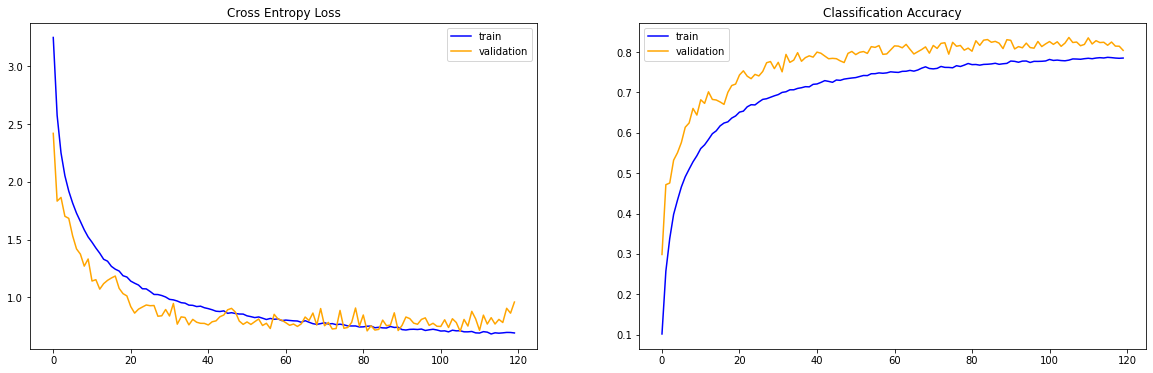

In [85]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

### Quite close to good fit
### Validation loss being slightly lower than training loss can be explained by regularization in the form of dropout layer and also data augmentation. These were applied only to the training dataset thus resulting in it being more "difficult" than validation images. This also explains higher classification accuracy for validation.

### Check model prediction for some image from validation just to see if it works

Predicted Alphabet is: ფ


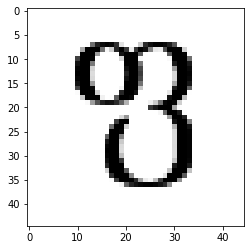

In [74]:
filename = r'./images/test/ფ/f_acad_30.png'
model = keras.models.load_model('./gmike19_model.h5')
image = Image.open(filename).convert('L').resize((45, 45))
plt.imshow(image, cmap='gray')
image = np.array(image.getdata(), dtype=np.uint8).reshape(image.size[0], image.size[1], number_of_channels)
image_array = []
image_array.append(image)
image_array = np.stack(image_array)
image_array = image_array / 255.0
result = model(image_array)
predicted_letter = list(letter_numbers.keys())[list(letter_numbers.values()).index(np.argmax(result) + 1)]
print ('Predicted Alphabet is: {}'.format(predicted_letter))